In [11]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from model_utils import *

## Model Deep Dive: CSOP

Using the CSOP Dataset, build a model that progressively accounts for different aspects of the data...

Team Composition:
- skill
- social_perceptivness
- cogStyleDiversity
- cogStyleSpeed

Task Features:
- complexity

Conversation Features (All)

In [12]:
# PARAMETERS
min_num_chats = 0
desired_target = "efficiency"
data_path = "../output/"
validation_results_output_name = "./csop_lasso_ridge_experiments_min_0_chats.csv"
test_results_output_name = "./csop_lasso_ridge_experiments_min_0_chats_test.csv"

In [15]:
def read_and_preprocess_data(path, min_num_chats):
    csop_conv_data  = pd.read_csv(path)

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    csop_conv_data = csop_conv_data[csop_conv_data["sum_num_messages"] >= min_num_chats]

    # Save the important information

    # Task and Composition features
    task_features = pd.get_dummies(csop_conv_data["complexity"])
    team_composition_features = csop_conv_data[["skill", "social_perceptiveness", "cogStyleDiversity", "skill_diversity"]]

    # possible targets to try
    targets = csop_conv_data[[desired_target,"score","normalized_score","duration"]]

    # Read in the config file and use that the drop the extraneous columns
    with open('./config.json', "rb") as json_file:
        config = json.load(json_file)

    conv_features = csop_conv_data.drop(config["csop"]['cols_to_ignore'], axis = 1)

    # Normalization
    team_composition_features = pd.DataFrame(StandardScaler().fit_transform(team_composition_features), columns = team_composition_features.columns)
    conv_features = pd.DataFrame(StandardScaler().fit_transform(conv_features), columns = conv_features.columns)
    # drop na cols
    conv_features = conv_features.dropna(axis = 1)

    targets = pd.DataFrame(StandardScaler().fit_transform(targets), columns = targets.columns)

    return team_composition_features, task_features, conv_features, targets

In [16]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + 'conv/csop_output_conversation_level.csv', min_num_chats=min_num_chats)

## Train-Test Split

In [17]:
X = pd.concat([task_features.reset_index(drop=True), team_composition_features.reset_index(drop=True), conv_features.reset_index(drop=True)], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, random_state=42, test_size=0.2)

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



In [ ]:
def get_optimal_alpha(y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [ ]:
def fit_regularized_linear_model(y_target, feature_columns_list, lasso = True, tune_alpha = False):

    if(tune_alpha == False):
        alpha = 1.0
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(y_target, feature_columns_list, lasso = True)

    if(lasso == True):
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    # Calculation of Q^2 metric
    

    
    model.fit(X_train[feature_columns_list], y_train[y_target])
    r2 = r2_score(y_true=y_test[y_target], y_pred=model.predict(X_test[feature_columns_list])).round(4)
    rmse = np.sqrt(mean_squared_error(y_true=y_test[y_target], y_pred=model.predict(X_test[feature_columns_list])).round(4)).round(4)

    print("R2: " + str(r2))
    print("RMSE: " + str(rmse))

    return (model, r2, rmse)

In [ ]:
def display_feature_coefficients(feature_columns_list, model):
    return(pd.DataFrame({'Feature': feature_columns_list, 'Coefficient': model.coef_}).sort_values('Coefficient'))

In [ ]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "r2": [],
    "rmse": []
}

result_df = pd.DataFrame(result)

## Team composition features

In [ ]:
model_ridge_composition, mrc_r2, mrc_rmse = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_composition], "model_type": ["Ridge"], "features_included": ["Team Composition"], "alpha": [model_ridge_composition.alpha.round(4)], "r2": [mrc_r2], "rmse": [mrc_rmse]})], ignore_index=True)

R2: -0.045
RMSE: 1.064


In [ ]:
display_feature_coefficients(team_composition_features.columns, model_ridge_composition)

,Feature,Coefficient
0,skill,-0.108107
1,social_perceptiveness,0.055363
2,cogStyleDiversity,0.120761
3,cogStyleSpeed,0.134163


In [ ]:
model_lasso_composition, mlc_r2, mlc_rmse = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_composition], "model_type": ["Lasso"], "features_included": ["Team Composition"], "alpha": [model_lasso_composition.alpha.round(4)], "r2": [mlc_r2], "rmse": [mlc_rmse]})], ignore_index=True)

R2: -0.0449
RMSE: 1.0639


## Task Features

In [ ]:
model_ridge_task, mrt_r2, mrt_rmse = fit_regularized_linear_model(desired_target, task_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_task], "model_type": ["Ridge"], "features_included": ["Task Complexity"], "alpha": [model_ridge_task.alpha.round(4)], "r2": [mrt_r2], "rmse": [mrt_rmse]})], ignore_index=True)

R2: 0.2919
RMSE: 0.8758


In [ ]:
display_feature_coefficients(task_features.columns, model_ridge_task)

,Feature,Coefficient
3,Very high,-0.645227
0,High,-0.419309
2,Moderate,-0.163190
1,Low,0.399339
4,Very low,0.828387


In [ ]:
model_lasso_task, mlt_r2, mlt_rmse = fit_regularized_linear_model(desired_target, task_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_task], "model_type": ["Lasso"], "features_included": ["Task Complexity"], "alpha": [model_lasso_task.alpha.round(4)], "r2": [mlt_r2], "rmse": [mlt_rmse]})], ignore_index=True)

R2: 0.292
RMSE: 0.8758


In [ ]:
display_feature_coefficients(task_features.columns, model_lasso_task)

,Feature,Coefficient
3,Very high,-0.480173
0,High,-0.254428
2,Moderate,-0.000000
1,Low,0.560582
4,Very low,0.989660


## Task + Composition Together

In [ ]:
task_comp_features = list(task_features.columns) + list(team_composition_features.columns)

model_ridge_taskcomp, mrtc_r2, mrtc_rmse = fit_regularized_linear_model(desired_target, task_comp_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_taskcomp], "model_type": ["Ridge"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_ridge_taskcomp.alpha.round(4)], "r2": [mrtc_r2], "rmse": [mrtc_rmse]})], ignore_index=True)

R2: 0.2683
RMSE: 0.8903


In [ ]:
display_feature_coefficients(task_comp_features, model_ridge_taskcomp)

,Feature,Coefficient
3,Very high,-0.640408
0,High,-0.419650
2,Moderate,-0.159932
5,skill,-0.098085
6,social_perceptiveness,0.053602
7,cogStyleDiversity,0.120557
8,cogStyleSpeed,0.123390
1,Low,0.405379
4,Very low,0.814612


In [ ]:
model_lasso_taskcomp, mltc_r2, mltc_rmse = fit_regularized_linear_model(desired_target, task_comp_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_taskcomp], "model_type": ["Lasso"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_lasso_taskcomp.alpha.round(4)], "r2": [mltc_r2], "rmse": [mltc_rmse]})], ignore_index=True)

R2: 0.2688
RMSE: 0.89


In [ ]:
display_feature_coefficients(task_comp_features, model_lasso_taskcomp)

,Feature,Coefficient
3,Very high,-0.476300
0,High,-0.255886
5,skill,-0.097181
2,Moderate,-0.000000
6,social_perceptiveness,0.052634
7,cogStyleDiversity,0.119719
8,cogStyleSpeed,0.122639
1,Low,0.561024
4,Very low,0.970398


## Conversation Alone

In [ ]:
model_lasso_comms, mlcom_r2, mlcom_rmse = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_comms], "model_type": ["Lasso"], "features_included": ["Communication"], "alpha": [model_lasso_comms.alpha.round(4)], "r2": [mlcom_r2], "rmse": [mlcom_rmse]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.545e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e-01, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e-01, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.710e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e-01, tolerance: 6.401e-02
Objective did n

R2: 0.2148
RMSE: 0.9223


In [ ]:
def print_lasso_coefs(X, model):

    coefficients = model.coef_
    
    # Get coefficients that are larger than minimal thresh = 0.001
    # This drops the worst coefficients in the graph and makes the image more readable
    MIN_THRESH = 0.001
    if(len(coefficients[abs(coefficients) > MIN_THRESH])>0):
        nonzero_coefficients,nonzero_indices = get_nonzero_lasso_coefs(coefficients, MIN_THRESH)
    else:
        MIN_THRESH = 0
        nonzero_coefficients,nonzero_indices = get_nonzero_lasso_coefs(coefficients, MIN_THRESH)

    nonzero_names = X.columns[nonzero_indices] 
    sorted_indices = np.argsort(np.abs(nonzero_coefficients))[::-1]
    sorted_coefficients = nonzero_coefficients[sorted_indices]
    sorted_names = nonzero_names[sorted_indices]

    fig, ax = plt.subplots(figsize=(20, 7))
    ax.barh(range(len(sorted_coefficients)), sorted_coefficients, color='steelblue')
    ax.invert_yaxis()

    coeff_range = np.abs(np.max(sorted_coefficients) - np.min(sorted_coefficients))
    offset = coeff_range * 0.03

    for i, (coefficient, name) in enumerate(zip(sorted_coefficients, sorted_names)):
        text_x = coefficient - offset if coefficient < 0 else coefficient + offset
        ax.text(text_x, i, f'{coefficient:.3f}', ha='left' if coefficient < 0 else 'right', va='center')

    ax.set_yticks(range(len(sorted_coefficients)))
    ax.set_yticklabels(sorted_names)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Coefficient Name')
    ax.set_title('Lasso Coefficients with CV-fitted alpha = ' + str(model.alpha.round(4)))

    plt.show()

def get_nonzero_lasso_coefs(coefficients, MIN_THRESH):
    nonzero_coefficients = coefficients[abs(coefficients) > MIN_THRESH]
    nonzero_indices = np.where(abs(coefficients) > MIN_THRESH)[0]
    return(nonzero_coefficients,nonzero_indices)

def plot_lasso_residuals(model):

    predicted_values = model.predict(self.X)
    residuals = self.y - predicted_values
    
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

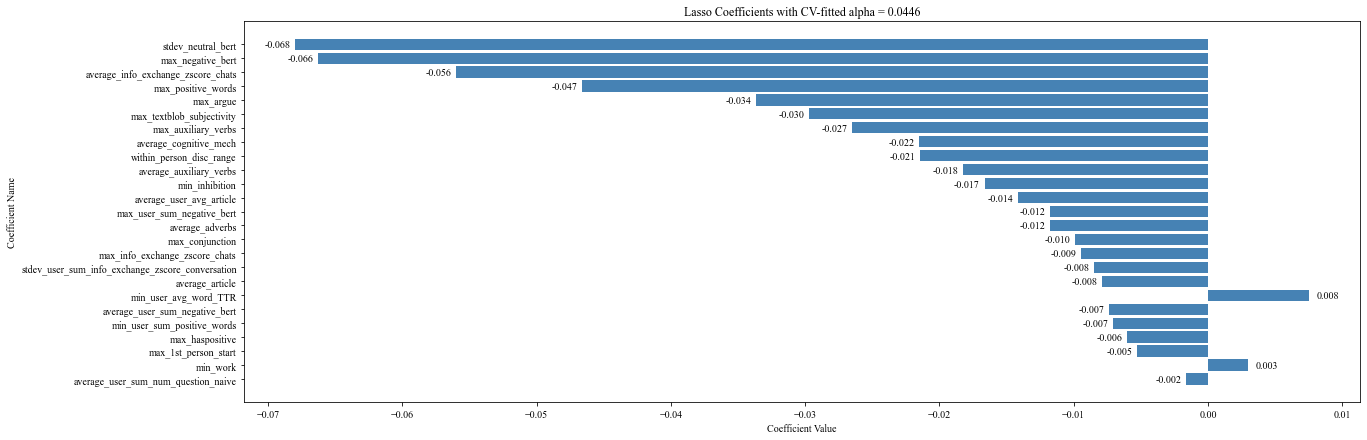

In [ ]:
print_lasso_coefs(conv_features, model_lasso_comms)

In [ ]:
display_feature_coefficients(conv_features.columns, model_lasso_comms)

,Feature,Coefficient
10,stdev_neutral_bert,-0.068019
8,max_negative_bert,-0.066281
25,average_info_exchange_zscore_chats,-0.056018
236,max_positive_words,-0.046597
208,max_argue,-0.033635
...,...,...
390,min_user_sum_neutral_bert,-0.000000
389,stdev_user_sum_neutral_bert,-0.000000
388,average_user_sum_neutral_bert,-0.000000
163,min_work,0.002989


In [ ]:
model_ridge_comms, mrcom_r2, mrcom_rmse = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_comms], "model_type": ["Ridge"], "features_included": ["Communication"], "alpha": [model_ridge_comms.alpha.round(4)], "r2": [mrcom_r2], "rmse": [mrcom_rmse]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.545e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e-01, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e-01, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.710e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e-01, tolerance: 6.401e-02
Objective did n

R2: -5.6619
RMSE: 2.6864


In [ ]:
display_feature_coefficients(conv_features.columns, model_ridge_comms)

,Feature,Coefficient
25,average_info_exchange_zscore_chats,-0.555750
13,average_num_words,-0.546877
27,min_info_exchange_zscore_chats,-0.534515
776,average_user_avg_num_words,-0.513037
201,average_article,-0.508009
...,...,...
783,max_user_avg_num_chars,0.846649
780,average_user_avg_num_chars,0.891401
17,average_num_chars,0.942075
19,min_num_chars,0.945222


## Conversation Features + Task Features

In [ ]:
convtask_features = list(task_features.columns) + list(conv_features.columns)
model_lasso_tconv, mltconv_r2, mltconv_rmse = fit_regularized_linear_model(desired_target, convtask_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_tconv], "model_type": ["Lasso"], "features_included": ["Task Complexity + Communication"], "alpha": [model_lasso_tconv.alpha.round(4)], "r2": [mltconv_r2], "rmse": [mltconv_rmse]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.508e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.156e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.844e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.369e-02, tolerance: 5.716e-02
Objective did n

R2: 0.4587
RMSE: 0.7658


In [ ]:
display_feature_coefficients(convtask_features, model_lasso_tconv)

,Feature,Coefficient
3,Very high,-0.353472
0,High,-0.185404
213,max_argue,-0.039897
15,stdev_neutral_bert,-0.038232
214,average_auxiliary_verbs,-0.037072
...,...,...
415,min_user_sum_info_exchange_zscore_conversation,0.017932
166,average_work,0.017988
324,min_deference,0.027891
1,Low,0.400033


In [ ]:
model_ridge_tconv, mrtconv_r2, mrtconv_rmse = fit_regularized_linear_model(desired_target, convtask_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_tconv], "model_type": ["Ridge"], "features_included": ["Task Complexity + Communication"], "alpha": [model_ridge_tconv.alpha.round(4)], "r2": [mrtconv_r2], "rmse": [mrtconv_rmse]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.508e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.156e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.844e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e-02, tolerance: 5.716e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.369e-02, tolerance: 5.716e-02
Objective did n

R2: -4.5342
RMSE: 2.4485


In [ ]:
display_feature_coefficients(convtask_features, model_lasso_tconv)

,Feature,Coefficient
3,Very high,-0.353472
0,High,-0.185404
213,max_argue,-0.039897
15,stdev_neutral_bert,-0.038232
214,average_auxiliary_verbs,-0.037072
...,...,...
415,min_user_sum_info_exchange_zscore_conversation,0.017932
166,average_work,0.017988
324,min_deference,0.027891
1,Low,0.400033


## Model with All Features

In [ ]:
all_features = list(task_features.columns) + list(team_composition_features.columns) + list(conv_features.columns)
model_lasso_all, mlall_r2, mlall_rmse = fit_regularized_linear_model(desired_target, all_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_all], "model_type": ["Lasso"], "features_included": ["All Features"], "alpha": [model_lasso_all.alpha.round(4)], "r2": [mlall_r2], "rmse": [mlall_rmse]})], ignore_index=True)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.453e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.659e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.711e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.700e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e-02, tolerance: 5.716e-02
Objective did n

R2: 0.4545
RMSE: 0.7687


In [ ]:
display_feature_coefficients(all_features, model_lasso_all)

,Feature,Coefficient
3,Very high,-0.350823
0,High,-0.184550
5,skill,-0.053508
217,max_argue,-0.046736
19,stdev_neutral_bert,-0.044764
...,...,...
6,social_perceptiveness,0.039598
8,cogStyleSpeed,0.071067
7,cogStyleDiversity,0.096023
1,Low,0.408310


In [ ]:
model_ridge_all, mrall_r2, mrall_rmse = fit_regularized_linear_model(desired_target, all_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_all], "model_type": ["Ridge"], "features_included": ["All Features"], "alpha": [model_ridge_all.alpha.round(4)], "r2": [mrall_r2], "rmse": [mrall_rmse]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.453e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.659e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.711e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.700e-02, tolerance: 6.401e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e-02, tolerance: 5.716e-02
Objective did n

R2: -6.1807
RMSE: 2.7891


In [ ]:
display_feature_coefficients(all_features, model_ridge_all)

,Feature,Coefficient
3,Very high,-0.763546
212,min_article,-0.546535
0,High,-0.511379
210,average_article,-0.508518
778,stdev_user_avg_negative_bert,-0.499810
...,...,...
779,min_user_avg_negative_bert,0.599488
791,min_user_avg_num_chars,0.873172
28,min_num_chars,0.918041
4,Very low,0.998894


# Dataframe that summarizes all these experiments!

In [ ]:
result_df.sort_values(by = "r2", ascending = False)

,model,model_type,features_included,alpha,r2,rmse
8,Lasso(alpha=0.017879918321882012),Lasso,Task Complexity + Communication,0.0179,0.4587,0.7658
10,Lasso(alpha=0.01735658343764668),Lasso,All Features,0.0174,0.4545,0.7687
3,Lasso(alpha=0.0003687229747749683),Lasso,Task Complexity,0.0004,0.2920,0.8758
2,Ridge(alpha=0.0003687229747749683),Ridge,Task Complexity,0.0004,0.2919,0.8758
5,Lasso(alpha=0.0008223089789029883),Lasso,Team Composition + Task Complexity,0.0008,0.2688,0.8900
4,Ridge(alpha=0.0008223089789029883),Ridge,Team Composition + Task Complexity,0.0008,0.2683,0.8903
6,Lasso(alpha=0.0445969568109222),Lasso,Communication,0.0446,0.2148,0.9223
1,Lasso(alpha=0.00013636379668891346),Lasso,Team Composition,0.0001,-0.0449,1.0639
0,Ridge(alpha=0.00013636379668891346),Ridge,Team Composition,0.0001,-0.0450,1.0640
9,Ridge(alpha=0.017879918321882012),Ridge,Task Complexity + Communication,0.0179,-4.5342,2.4485


In [ ]:
# Save for comparing results
result_df.sort_values(by = "r2", ascending = False).to_csv(validation_results_output_name)

Questions:
- More deeply understand difference between LASSO and Ridge
- Better understand `alpha` hyperparameter
- Why doesn't more features mean a better R^2? (Wouldn't the model 'throw out' features that don't work?)

## "Out of Sample" Testing (Using CSOP II)

#### TODO -- account for diffs in formatting between the two datasets and clean up the formatting

In [ ]:
# Preprocess CSOP 2 to look like CSOP 1
csop2_path = data_path + 'csopII_output_conversation_level.csv'
csop2_conv_data  = pd.read_csv(csop2_path)

csop2_conv_data = csop2_conv_data[csop2_conv_data["sum_num_messages"] >= min_num_chats]

In [ ]:
# Test only on the case where the team size = 3
csop2_conv_data = csop2_conv_data[csop2_conv_data["team_size"] == 3]

In [ ]:
# First, get the task features
csop2_conv_data["difficulty"] = csop2_conv_data["difficulty"].map({
    "Easy [Corresponds to 'Hard' in PNAS]": "Moderate",
    "Hard [Corresponds to 'Super Hard' in PNAS]": "Very high"
})
task_features_test = csop2_conv_data["difficulty"]


In [ ]:
task_features_test = pd.get_dummies(csop2_conv_data["difficulty"])
task_features_test["High"] = 0
task_features_test["Low"] = 0
task_features_test["Very low"] = 0
task_features_test = task_features_test[task_features.columns]

Composition Features
- team_size: Team Size (1-10)
- soc_pers: Social Perceptiveness * (this is the only thing in common with CSOP 1)
- vis_img: Visual Imagery
- int_verb: Internal Verbalization
- ort_img: Orthographic Imagery
- rep_man: Representational Manipulation

The problem is that all these are categorical (e.g., "High", "Mixed", "Low") --- can't be used

In [ ]:
team_composition_features_test = csop2_conv_data[["int_verb", "vis_img", "ort_img", "rep_man", "soc_pers", "team_size"]]

In [ ]:
def drop_non_common_columns(dfs):
	"""
	Drops any columns that are not shared between dataframes,
	so that they can be plotted on the same axis.

	@param dfs: list of dataframes
	"""

	# Check if there are any data frames in the list
	if not dfs:
		return []

	# Find the intersection of columns in all data frames
	common_columns = set(dfs[0].columns)
	for df in dfs[1:]:
		common_columns = common_columns.intersection(df.columns)

	# Create a new list of data frames with only common columns
	new_data_frames = []
	for df in dfs:
		new_data_frames.append(df[list(common_columns)])

	return new_data_frames

In [ ]:
# possible targets to try
targets_test = csop2_conv_data[[desired_target,"score","duration"]]
targets_test = pd.DataFrame(StandardScaler().fit_transform(targets_test), columns = targets_test.columns)

# Read in the config file and use that the drop the extraneous columns
with open('./config.json', "rb") as json_file:
    config = json.load(json_file)

conv_features_test = csop2_conv_data.drop(config["csopII"]['cols_to_ignore'], axis = 1)

In [ ]:
# Normalization
conv_features_test = pd.DataFrame(StandardScaler().fit_transform(conv_features_test), columns = conv_features_test.columns)
# drop na cols
conv_features_test = conv_features_test.dropna(axis = 1)

In [ ]:
# drop cols that aren't in csop I and reorder them the match
_ , conv_features_test = drop_non_common_columns([conv_features, conv_features_test])
conv_features_test = conv_features_test[conv_features.columns]

In [ ]:
X_test = pd.concat([task_features_test.reset_index(drop=True), ≈.reset_index(drop=True)], axis=1)

## Pass the desired trained model in from the earlier steps

In [ ]:
out_of_sample_test_results = pd.DataFrame(
    {
        "model": [],
        "features_included": [],
        "r2": [],
        "rmse": []
    }
)

models = [model_lasso_task, model_lasso_tconv, model_lasso_comms]
features = ["Task Complexity", "Task Complexity + Communication", "Communication"]
feature_lists = [list(task_features_test.columns), list(task_features_test.columns) + list(conv_features_test.columns), list(conv_features_test.columns)]

for i in range(len(models)):
    model = models[i]
    feature = features[i]
    feature_list = feature_lists[i]

    r2 = r2_score(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)
    rmse = np.sqrt(mean_squared_error(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)).round(4)
    out_of_sample_test_results = pd.concat([out_of_sample_test_results, pd.DataFrame({"model": [model], "features_included": [feature], "r2": [r2], "rmse": [rmse]})], ignore_index=True)

In [ ]:
out_of_sample_test_results

,model,features_included,r2,rmse
0,Lasso(alpha=0.0003687229747749683),Task Complexity,-0.1941,1.0927
1,Lasso(alpha=0.017879918321882012),Task Complexity + Communication,0.1355,0.9298
2,Lasso(alpha=0.0445969568109222),Communication,0.2490,0.8666


In [ ]:
out_of_sample_test_results.sort_values(by = "r2", ascending = False).to_csv(test_results_output_name)